### Kaggle Competition -- Titianic Survival Prediction

https://www.kaggle.com/c/titanic-gettingStarted

In [1]:
'''
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
'''
import numpy as np

In [2]:
embark_stations={'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'}
embark_port={1:'Cherbourg', 2:'Queenstown', 3:'Southampton'}
social_pclass ={1:'Upper',2:'Middle',3:'Lower'}

First, we will load the **data into an array of dictionaries**. The load_data function defined below can be used to load both training and test data.

See:  http://scikit-learn.org/stable/modules/feature_extraction.html#dict-feature-extraction

In [3]:
import numpy as np
import csv
def load_data(path, is_training):
    """
    is_training = 
        True:  Return raw Training Set and Labels
        False: Return raw Test Set
    """
    with open(path) as csvfile:
        training_file = csv.DictReader(csvfile)
        data = []
        labels = []
        for row in training_file:
            if is_training:
                labels.append(row['Survived'])
                del row['Survived'] # we can't train on survived!
            del row['Name'] # for simplicity, we won't try to analyze name, ticket, or cabin
            del row['Ticket']
            del row['Cabin']
            try:
                row['fare'] = min(250., float(row['Fare'])) # And lets convert strings to floats/ints as makes sense
            except ValueError:
                row['fare'] = 20.
            try:
                row['age'] = float(row['Age'])
            except ValueError:
                row['age'] = 30. # assign an "average" age for now, (assigning "None" causes errors)
            row['sibsp'] = int(row['SibSp'])
            row['parch'] = int(row['Parch'])
            row['pclass'] = int(row['Pclass'])
            row['embarked'] = row['Embarked'] if row['Embarked'] else 'S'
            data.append(row)
        if is_training:    
            return np.array(data), np.array(labels)
        else:
            return np.array(data)

training_data, labels = load_data('data/train.csv', True)    

## Compare this with the Pandas way of doing the same thing as above

In [4]:
import pandas as pd

def fillna_by_common(S):
    #replace NaNs by the most common occuring element
    histS=S.value_counts().to_dict()
    common=max(histS,key=histS.get)
    return S.fillna(common)

def load_dataframe(fname='data/train.csv', is_training=True):
    #read csv file to pandas data frame
    df = pd.read_csv(fname)    
    df_orig=df.copy()
    
    #drop columns
    df.drop(['Name', 'Ticket', 'Cabin'],axis=1,inplace=True) 
    
    #fill the missing Age data by the mean Age 
    age_mean = max([0,df['Age'].mean()])
    df['Age'] = df['Age'].fillna(age_mean)
    
    #For the column Fare, however, it makes sense to fill in the 
    #NaN values with the mean by the column Pclass, or Passenger class.
    
    fare_means = df.pivot_table('Fare', index='Pclass', aggfunc='mean')
    #print fare_means
    df['Fare'] = df[['Fare', 'Pclass']].apply(lambda x:
                            fare_means[x['Pclass']] if pd.isnull(x['Fare'])
                            else x['Fare'], axis=1)

    #fill the missing data for Sex and Embarked columns
    df['Sex']=fillna_by_common(df['Sex'])
    df['Embarked'] = fillna_by_common(df['Embarked'])
    
    #create Gender labels and Port numbers from Sex and Embarked columns
    df['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)
    df['Port']=df['Embarked'].map({'C':0,'Q':1,'S':2})
    
    #no need to keep the Sex and Embarked columns, drop them
    df.drop(['Sex', 'Embarked'],axis=1,inplace=True) 
    
    return df, df_orig

In [5]:
#load training data set
df,df_orig=load_dataframe()
labels2 = df['Survived'].values
training_data2=df.drop(['Survived'],axis=1).values
print 'predictors data type',type(training_data2)
print 'target data type', type(labels2)

#df_orig.info()
df.info()

predictors data type <type 'numpy.ndarray'>
target data type <type 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Gender         891 non-null int64
Port           891 non-null int64
dtypes: float64(2), int64(7)
memory usage: 69.6 KB


In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Visualizing the missing data

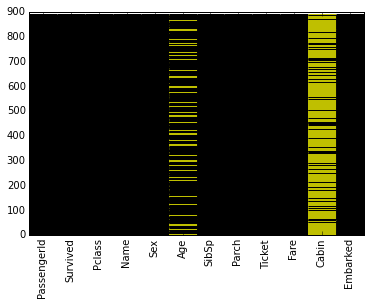

In [7]:
def missmap(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    dfn = pd.isnull(df)
    ny = len(df)
    nx = len(df.columns)
    dfn = pd.isnull(df)
    x = np.arange(len(df.columns))
    xgrid = np.tile(x, (len(df), 1)).T
    c = {True: 'y', False: 'k'}
    ax.set_xlim(0, nx)
    for x, col in zip(xgrid, dfn.columns):
        yvals = dfn[col]
        ax.bar(x, yvals, bottom=np.arange(1, ny+1), width=1,
               color=dfn[col].map(c), edgecolor=dfn[col].map(c))
    ax.set_xticks(.5 + np.arange(nx))
    ax.set_xticklabels(dfn.columns)
    for t in ax.get_xticklabels():
        t.set_rotation(90)
    return ax

missmap(df_orig)

## At this stage the data is clean and we are ready to apply a Machine learning analysis.  

It is, however, instructive to visualize our data to build some intution.
For doing so we will try taking a look at the feature distribution, by using Python's matplotlib.

In [8]:
# Used so that when we call plt.show(), the graphs show up inside iPython Notebook
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

## Let us explore the survival propability as a function of age and social class

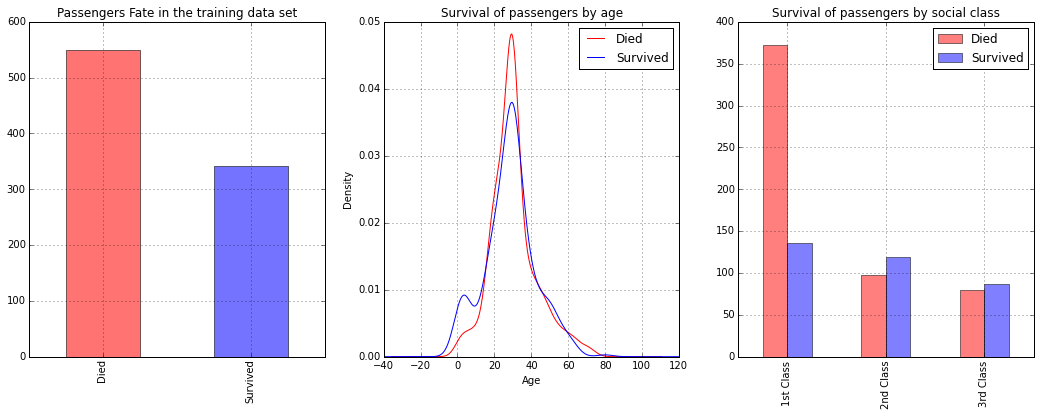

In [13]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
 
ax1 = plt.subplot('131')
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart,color=['r','b'])
ax1.set_xticklabels(['Died', 'Survived'])
plt.title("Passengers Fate in the training data set")    

ax2=plt.subplot('132')
#plot the kernel desnsity estimate of age distribution of those who died or survived
df.Age[df.Survived==0].plot(kind='kde', color='r',label='Died')
df.Age[df.Survived==1].plot(kind='kde', color='b',label='Survived')
plt.xlabel("Age") 
plt.legend(loc='best')
plt.title("Survival of passengers by age")

ndf = pd.DataFrame({'Died':df.Pclass[df.Survived==0].value_counts().values, 
                    'Survived':df.Pclass[df.Survived==1].value_counts().values})
ax3=plt.subplot('133')
ndf.plot(kind='bar',color=['r','b'],alpha=0.5,ax=ax3)
ax3.set_xticklabels(['1st Class', '2nd Class','3rd Class'])
plt.legend(loc='best')
plt.title("Survival of passengers by social class")

## Let us explore the age distribution  as a function of social class 

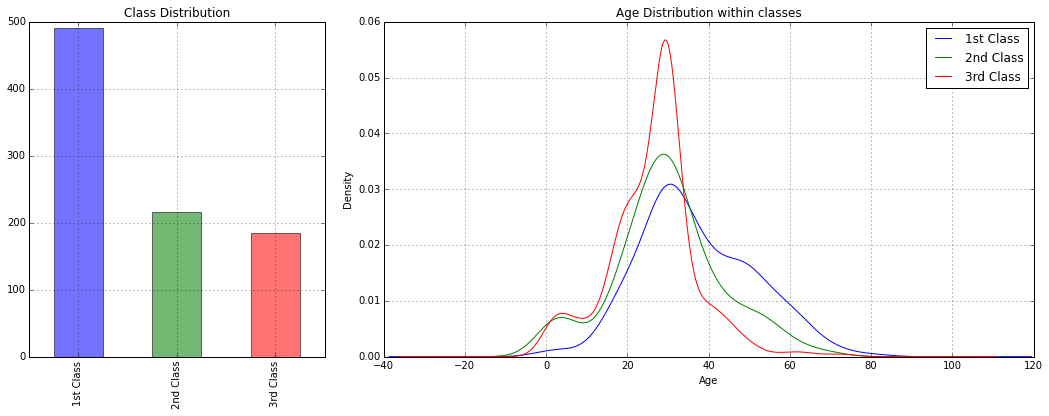

In [14]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 

ax1 = plt.subplot('131')
df.Pclass.value_counts().plot(kind="bar", alpha=alpha_bar_chart,color=['b','g','r'])
ax1.set_xticklabels(['1st Class', '2nd Class','3rd Class'])
plt.title("Class Distribution")

ax2=plt.subplot2grid((1,3),(0,1), colspan=2)
# plots a kernel desnsity estimate of the subset of the 1st class passanges's age
df.Age[df.Pclass == 1].plot(kind='kde',ax=ax2)    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
# plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

## Now let us see the effect of embarkation on survival 

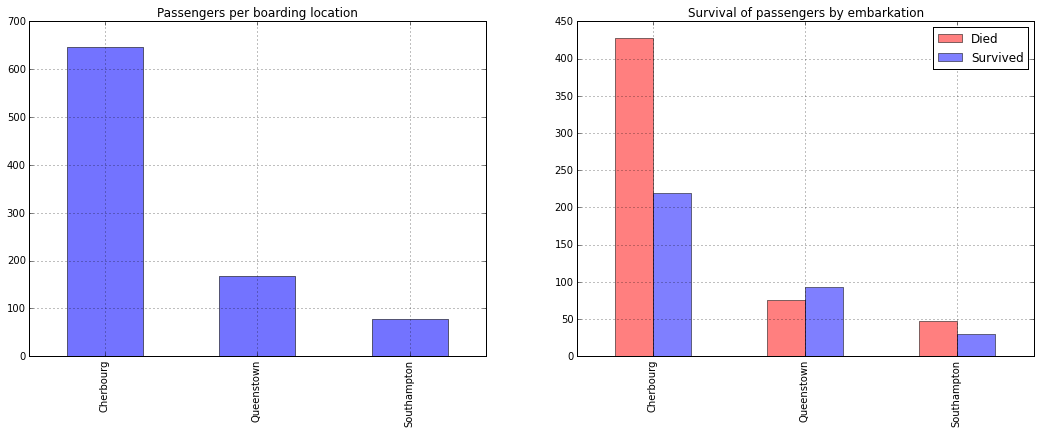

In [15]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 

ax1 = plt.subplot('121')
#plot port
df.Port.value_counts().plot(kind='bar', alpha=alpha_bar_chart) #,color=['b','g','r']
ax1.set_xticklabels(embark_port.values())
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

ndf = pd.DataFrame({'Died':df.Port[df.Survived==0].value_counts().values, 
                    'Survived':df.Port[df.Survived==1].value_counts().values})
ax3=plt.subplot('122')
ndf.plot(kind='bar',color=['r','b'],alpha=0.5,ax=ax3)
ax3.set_xticklabels(embark_port.values())
plt.legend(loc='best')
plt.title("Survival of passengers by embarkation")

## Scikit-learn - Training the model

First let's use the decision tree learning machine classifier algorithm from scikit-learn. 

In [16]:
# Now lets build a decision tree
from sklearn import tree
classifier = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=4)
classifier.fit(training_data2, labels2)
# let's see how our decision tree works agains the training data (should be near-perfect)
print "First 5 training labels"
print labels[0:5]
print "Prediction on first 5 training Rows"
print classifier.predict(training_data2[0:5])

First 5 training labels
['0' '1' '1' '1' '0']
Prediction on first 5 training Rows
[0 1 1 1 0]


In [17]:
df.keys()

Index([u'PassengerId', u'Survived', u'Pclass', u'Age', u'SibSp', u'Parch', u'Fare', u'Gender', u'Port'], dtype='object')

## Now lets Try Graphing our decision tree classifier

In [19]:
# Dependencies: pydot, graphviz
# sudo pip install pydot
# brew install graphviz
import StringIO, pydot 
dot_data = StringIO.StringIO() 
tree.export_graphviz(classifier, out_file=dot_data, feature_names=df.keys()) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("decision_tree.png") 

True

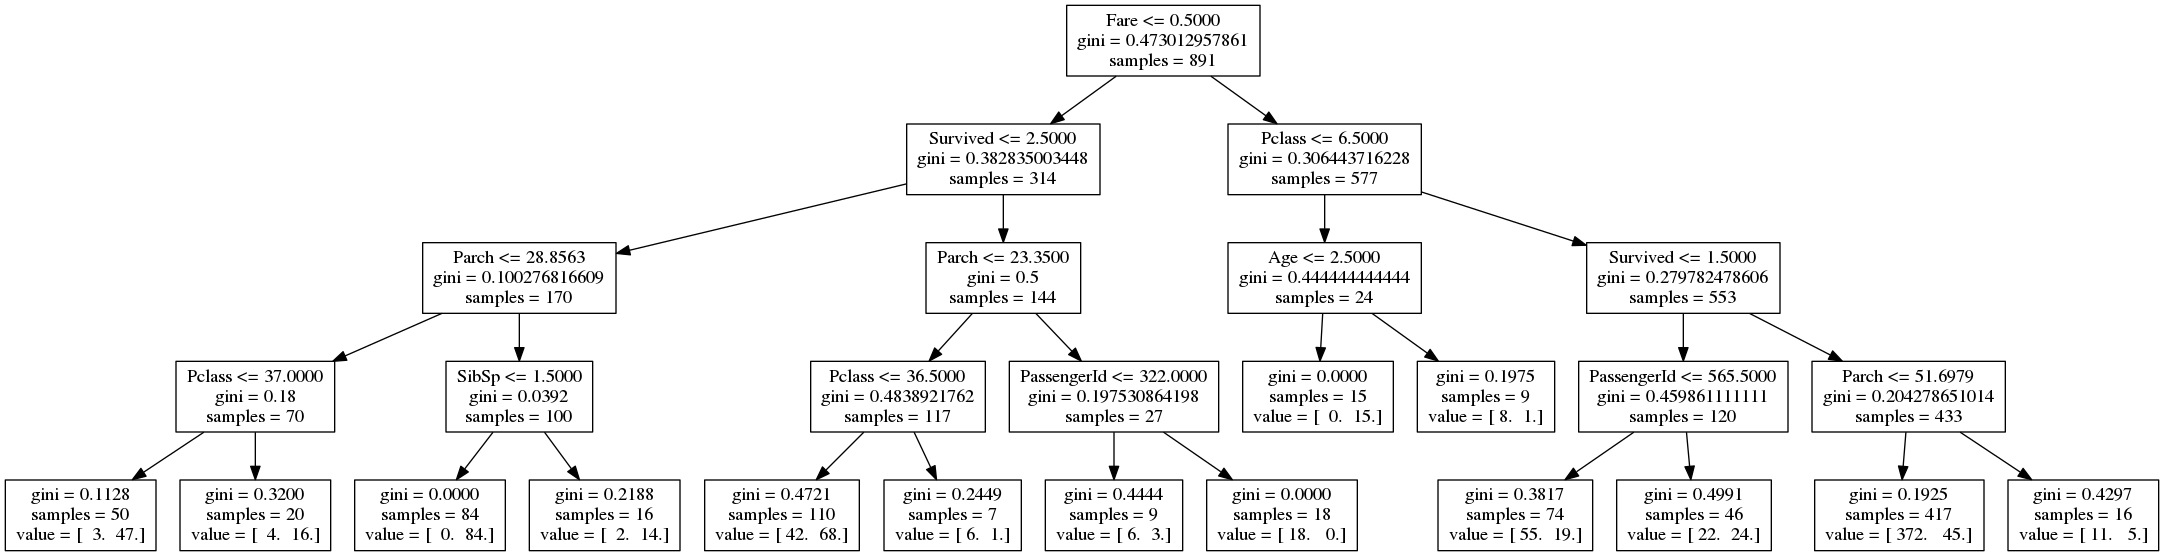

In [20]:
from IPython.core.display import Image 
Image(filename='decision_tree.png') 

### Let us now load the test data set and test and evaluate the performance 

In [21]:
#load test data set
df_test,df_test_orig=load_dataframe(fname='data/test.csv')
test_data=df_test.values
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Gender         418 non-null int64
Port           418 non-null int64
dtypes: float64(2), int64(6)
memory usage: 29.4 KB


/usr/lib/python2.7/dist-packages/pandas/core/index.py:631: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  type(self).__name__),FutureWarning)


In [22]:
# Now lets try running it on the test set, and take a look at the first 5 rows

predictions = classifier.predict(test_data)
print "Tree classifier prediction on first 5 test rows"
print predictions[0:5]

# Now lets output all our predictions to a csv file
with open('prediction.csv', 'w') as csvfile:
    for survived in predictions:
        csvfile.write("{}\n".format(survived))
print 'Result for test data is written to a file prediction.csv!'

Tree classifier prediction on first 5 test rows
[0 0 0 0 1]
Result for test data is written to a file prediction.csv!


In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)
model = model.fit(training_data2,labels2)
output = model.predict(test_data)
print "Tree classifier prediction on first 5 test rows"


Tree classifier prediction on first 5 test rows


(418,)
(418,)


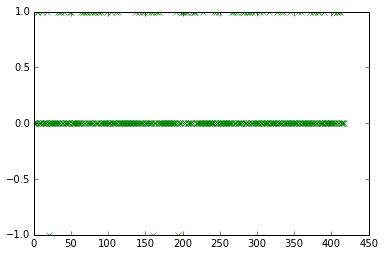

In [25]:
#Compare predictions from tree vs forest  
print predictions.shape
print output.shape
plt.plot(predictions-output,linestyle='',marker='x',color='g')
#plt.plot(predictions,linestyle='',marker='o',color='r')

### APPENDIX

As an alternative method, instead of using dictionaries, we can load the data into arrays. This is "rawer" and faster, but perhaps less convenient to work with. 

In [26]:
import csv
import numpy as np

data = []
with open('data/train.csv', 'rb') as csvfile:
    csvreader = csv.reader(csvfile)
    header = csvreader.next()
    for row in csvreader:
        data.append(row)

data = np.array(data)
        
print "header : {}".format(header)
print "1st row: {}".format(data[0])

header : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
1st row: ['1' '0' '3' 'Braund, Mr. Owen Harris' 'male' '22' '1' '0' 'A/5 21171'
 '7.25' '' 'S']


Let's learn about how to transform categorical data into something that scikit-learn can read (One-Hot encoding). 

This estimator transforms each categorical feature with m possible values into m binary features, with only one active. THUS, each categorical feature blows up into m more features, increasing the size of your feature vector by a lot.

see: http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features

In [27]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit([[0],[1],[2]]) # Assume we have a data set of Red, Yello, Green, like a stoplight

#Lets transform a Red (the first) into One-Hot encoding
enc.transform([[0]]).toarray()


array([[ 1.,  0.,  0.]])

In [28]:
# Now lets try seeing what Red, Yellow, Green encodes to:
enc.transform([[0],[1],[2]]).toarray()

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])